# QUESTIONS?

1.   The destination and origin code is not restricted to London? The localizer has 17.636 but in the dataset, there are more hexagons
2.   Am I correct to sum the two data frames, Origin and Destination, or am I overlapping the flows?
3.





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install Packages
!pip install h3 --quiet
!pip install area --quiet
!pip install matplotlib_scalebar --quiet
!pip install geodatasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as img
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from geodatasets import get_path
import folium
import statsmodels.api as sm
import h3
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt
import requests
import seaborn as sn

In [4]:
path = '/content/drive/My Drive/Colab/'

In [5]:
# locomizer hexagon grid at level 8
grid8 = gpd.read_file(path + 'grid7.json')

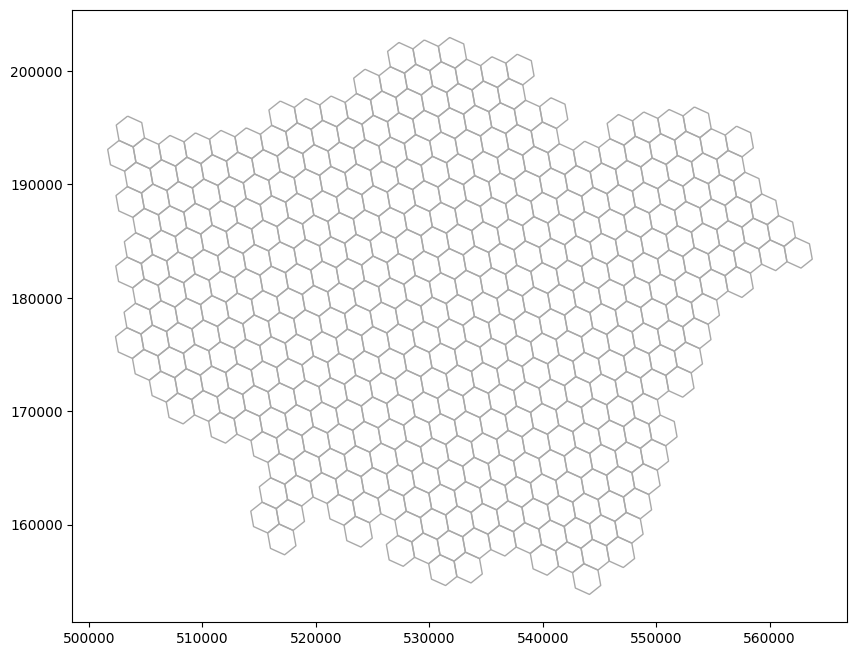

In [6]:
#transform london to BNG
grid8.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
grid8.plot(figsize = (10,15), facecolor = "None", edgecolor = "darkgray")
plt.show()

In [7]:
#order it by borough code - *This step will be important later on*
grid8.sort_values(by=["_index"], inplace = True)

#extract the centroids
grid8["Centroids"] = grid8.geometry.centroid



In [8]:
# set the index
London = grid8
London.set_index('_index', inplace=True, drop=True)

#calculate distances from all Hex centroids to all Hex centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

London

,_index,geometry,Centroids
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310)
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811)
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736)
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971)
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092)
...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377)
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413)
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499)
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204)


In [9]:
distances

,Orig,Dest,Dist
0,87194ac00ffffff,87194ac00ffffff,0.000000
1,87194ac00ffffff,87194ac01ffffff,2430.565498
2,87194ac00ffffff,87194ac02ffffff,2251.874795
3,87194ac00ffffff,87194ac03ffffff,2276.072309
4,87194ac00ffffff,87194ac04ffffff,2275.476462
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,10156.365660
172221,87195db6bffffff,87195db5cffffff,8290.118175
172222,87195db6bffffff,87195db5dffffff,6740.416649
172223,87195db6bffffff,87195db69ffffff,2245.531445


In [ ]:
od = pd.read_csv(path + "Audience_Profiles_Destination_2023-03-08.tsv", sep="\t", low_memory=False)

In [ ]:
#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



#pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [ ]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)
pivot['ORIGIN_CODE'] = pivot['ORIGIN_CODE'].astype(str)
#check the results

OD3 =  pivot

OD3

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS
0,0,89194ac2ea3ffff,0.0,0.0
1,0,89194ac2ed7ffff,0.0,0.0
2,0,89194ad51c3ffff,0.0,0.0
3,0,89194ad51cbffff,0.0,0.0
4,0,89194ad51dbffff,0.0,0.0
...,...,...,...,...
611991,891976d80b3ffff,89194ac365bffff,21.0,0.0
611992,891976d80b3ffff,89194ac3663ffff,21.0,0.0
611993,891976d80b3ffff,89194ad1023ffff,21.0,0.0
611994,891976d80b3ffff,89194ad10abffff,21.0,0.0


In [ ]:
unique_strings = OD3['ORIGIN_CODE'].unique()
unique_strings2 = OD3['DESTINATION_CODE'].unique()

count_total = len(unique_strings)
print(count_total)

count_total2 = len(unique_strings2)
print(count_total2)

63733
15936


In [ ]:
unique_strings

array(['0', '8918218800fffff', '89182189087ffff', ..., '891976d496fffff',
       '891976d6b53ffff', '891976d80b3ffff'], dtype=object)

In [ ]:
# Remove rows with value '0' in 'ORIGIN_CODE'
test = OD3[OD3['ORIGIN_CODE'] != '0']

In [ ]:
unique_strings3 = test['ORIGIN_CODE'].unique()

count_total3 = len(unique_strings3)
count_total3

63732

In [ ]:
count_total3

63732

In [ ]:
od = pd.read_csv(path + "Audience_Profiles_Origin_2023-03-08.tsv", sep="\t", low_memory=False)

In [ ]:
#subset daily

daily_OD = od[(od['TIME INTERVAL'] == 25) & (od.MOVEMENT_MODALITY=='ALL')][['ORIGIN_CODE', 'DESTINATION_CODE', 'EXTRAPOLATED_NUMBER_OF_USERS', 'VISITATION_MODALITY']]



#create pivot table and replace nan with 0 and rename index as index

pivot = daily_OD.pivot_table(

    index=['ORIGIN_CODE', 'DESTINATION_CODE'],

    columns='VISITATION_MODALITY',

    values='EXTRAPOLATED_NUMBER_OF_USERS',

    aggfunc='sum').fillna(0).reset_index()



pivot.columns.name = None



#pivot['TRANSIENTS'] =  pivot['ALL'] - pivot['WORKERS']

In [ ]:
# Convert 'ORIGIN_CODE' column to string
pivot['DESTINATION_CODE'] = pivot['DESTINATION_CODE'].astype(str)

# Remove rows with value '0' in 'ORIGIN_CODE'
#OD4 = pivot[pivot['DESTINATION_CODE'] != '0']

#check the results
OD4 = pivot
OD4

,ORIGIN_CODE,DESTINATION_CODE,ALL,WORKERS
0,89194ac0003ffff,89194ac0003ffff,64.0,64.0
1,89194ac0003ffff,89194ac000bffff,21.0,0.0
2,89194ac0003ffff,89194ac001bffff,21.0,0.0
3,89194ac0003ffff,89194ac006bffff,21.0,0.0
4,89194ac0003ffff,89194ac0073ffff,21.0,0.0
...,...,...,...,...
2918586,89195db6bbbffff,89195db6bb3ffff,21.0,0.0
2918587,89195db6bbbffff,89195db6bb7ffff,42.0,0.0
2918588,89195db6bbbffff,89195db6bbbffff,85.0,0.0
2918589,89195db6bbbffff,89195db6bcbffff,21.0,0.0


In [ ]:
unique_strings = OD4['ORIGIN_CODE'].unique()
unique_strings2 = OD4['DESTINATION_CODE'].unique()

count_total = len(unique_strings)
print(count_total)

count_total2 = len(unique_strings2)
print(count_total2)

17636
186704


In [ ]:
# Remove rows with value '0' in 'ORIGIN_CODE'
OD4 = OD4[OD4['DESTINATION_CODE'] != '0']

# Remove rows with value '0' in 'ORIGIN_CODE'
OD3 = OD3[OD3['ORIGIN_CODE'] != '0']

In [ ]:
OD3.drop(columns=['ALL'], inplace=True)


<ipython-input-23-e9d5709a1afa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD3.drop(columns=['ALL'], inplace=True)


In [ ]:
OD4.drop(columns=['ALL'], inplace=True)

<ipython-input-24-6a3cb1bc38b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OD4.drop(columns=['ALL'], inplace=True)


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
merged_df = pd.merge(OD3, OD4, on=['ORIGIN_CODE', 'DESTINATION_CODE'], how= 'outer').fillna(0)

In [ ]:
merged_df

,ORIGIN_CODE,DESTINATION_CODE,WORKERS_x,WORKERS_y
0,8918218800fffff,89194e6854fffff,0.0,0.0
1,8918218800fffff,89194e68c47ffff,0.0,0.0
2,8918218800fffff,89194e68ea3ffff,0.0,0.0
3,8918218800fffff,89194e68eabffff,0.0,0.0
4,8918218800fffff,89194e69083ffff,0.0,0.0
...,...,...,...,...
3244046,89195db6bbbffff,89195db6b8fffff,0.0,0.0
3244047,89195db6bbbffff,89195db6ba3ffff,0.0,0.0
3244048,89195db6bbbffff,89195db6bb3ffff,0.0,0.0
3244049,89195db6bbbffff,89195db6bcbffff,0.0,0.0


In [ ]:
# Create a new column 'check' based on the condition
merged_df['check'] = merged_df['WORKERS_x'] == merged_df['WORKERS_y']

# Convert boolean values to 'True' or 'False'
merged_df['check'] = merged_df['check'].astype(bool)

merged_df

,ORIGIN_CODE,DESTINATION_CODE,WORKERS_x,WORKERS_y,check
0,8918218800fffff,89194e6854fffff,0.0,0.0,True
1,8918218800fffff,89194e68c47ffff,0.0,0.0,True
2,8918218800fffff,89194e68ea3ffff,0.0,0.0,True
3,8918218800fffff,89194e68eabffff,0.0,0.0,True
4,8918218800fffff,89194e69083ffff,0.0,0.0,True
...,...,...,...,...,...
3244046,89195db6bbbffff,89195db6b8fffff,0.0,0.0,True
3244047,89195db6bbbffff,89195db6ba3ffff,0.0,0.0,True
3244048,89195db6bbbffff,89195db6bb3ffff,0.0,0.0,True
3244049,89195db6bbbffff,89195db6bcbffff,0.0,0.0,True


In [ ]:
uniq = merged_df['check'].unique()
uniq

array([ True, False])

In [ ]:
# Filter the DataFrame to show only rows where 'check' is False
filtered_df = merged_df[merged_df['check'] == False]
filtered_df

,ORIGIN_CODE,DESTINATION_CODE,WORKERS_x,WORKERS_y,check
13,8918218800fffff,89195da6073ffff,21.0,0.0,False
15,89182189087ffff,89194e69a17ffff,21.0,0.0,False
22,891821c456bffff,89194ada6a7ffff,21.0,0.0,False
25,89182500093ffff,89194ad2593ffff,21.0,0.0,False
50,891825013a7ffff,89194ad1b4fffff,21.0,0.0,False
...,...,...,...,...,...
3243045,89195db6b87ffff,8919556467bffff,0.0,21.0,False
3243218,89195db6b8fffff,89194e482d3ffff,0.0,21.0,False
3243409,89195db6ba7ffff,8919599ad93ffff,0.0,21.0,False
3243860,89195db6bafffff,89197264e17ffff,0.0,21.0,False


In [ ]:
# Create a new column containing the sum of 'WORKERS_x' and 'WORKERS_y'
filtered_df['Total'] = filtered_df['WORKERS_x'] + filtered_df['WORKERS_y']
filtered_df

<ipython-input-30-3cdae79dd822>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Total'] = filtered_df['WORKERS_x'] + filtered_df['WORKERS_y']


,ORIGIN_CODE,DESTINATION_CODE,WORKERS_x,WORKERS_y,check,Total
13,8918218800fffff,89195da6073ffff,21.0,0.0,False,21.0
15,89182189087ffff,89194e69a17ffff,21.0,0.0,False,21.0
22,891821c456bffff,89194ada6a7ffff,21.0,0.0,False,21.0
25,89182500093ffff,89194ad2593ffff,21.0,0.0,False,21.0
50,891825013a7ffff,89194ad1b4fffff,21.0,0.0,False,21.0
...,...,...,...,...,...,...
3243045,89195db6b87ffff,8919556467bffff,0.0,21.0,False,21.0
3243218,89195db6b8fffff,89194e482d3ffff,0.0,21.0,False,21.0
3243409,89195db6ba7ffff,8919599ad93ffff,0.0,21.0,False,21.0
3243860,89195db6bafffff,89197264e17ffff,0.0,21.0,False,21.0


In [ ]:
# Create a new column based on conditions
merged_df['FLOWS'] = np.where(merged_df['WORKERS_x'] == merged_df['WORKERS_y'], merged_df['WORKERS_y'], merged_df['WORKERS_x'] + merged_df['WORKERS_y'])
merged_df

,ORIGIN_CODE,DESTINATION_CODE,WORKERS_x,WORKERS_y,check,FLOWS
0,8918218800fffff,89194e6854fffff,0.0,0.0,True,0.0
1,8918218800fffff,89194e68c47ffff,0.0,0.0,True,0.0
2,8918218800fffff,89194e68ea3ffff,0.0,0.0,True,0.0
3,8918218800fffff,89194e68eabffff,0.0,0.0,True,0.0
4,8918218800fffff,89194e69083ffff,0.0,0.0,True,0.0
...,...,...,...,...,...,...
3244046,89195db6bbbffff,89195db6b8fffff,0.0,0.0,True,0.0
3244047,89195db6bbbffff,89195db6ba3ffff,0.0,0.0,True,0.0
3244048,89195db6bbbffff,89195db6bb3ffff,0.0,0.0,True,0.0
3244049,89195db6bbbffff,89195db6bcbffff,0.0,0.0,True,0.0


In [ ]:
merged_df.drop(columns=['WORKERS_x','WORKERS_y','check'], inplace=True)

In [ ]:
merged_df

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,8918218800fffff,89194e6854fffff,0.0
1,8918218800fffff,89194e68c47ffff,0.0
2,8918218800fffff,89194e68ea3ffff,0.0
3,8918218800fffff,89194e68eabffff,0.0
4,8918218800fffff,89194e69083ffff,0.0
...,...,...,...
3244046,89195db6bbbffff,89195db6b8fffff,0.0
3244047,89195db6bbbffff,89195db6ba3ffff,0.0
3244048,89195db6bbbffff,89195db6bb3ffff,0.0
3244049,89195db6bbbffff,89195db6bcbffff,0.0


In [ ]:
OD = merged_df

In [ ]:
# Assuming 'ORIGIN_CODE' and 'DESTINATION_CODE' are H3 level 9 indices (hexagons)
# You can create a new column with H3 level 8 indices based on the level 9 indices
OD['ORIGIN_CODE_LEVEL_8'] = OD['ORIGIN_CODE'].apply(lambda x: h3.h3_to_parent(x, 7))
OD['DESTINATION_CODE_LEVEL_8'] = OD['DESTINATION_CODE'].apply(lambda x: h3.h3_to_parent(x, 7))

# Group by the new level 8 indices and sum the 'FLOWS' values
aggregated_OD = OD.groupby(['ORIGIN_CODE_LEVEL_8', 'DESTINATION_CODE_LEVEL_8'])['FLOWS'].sum().reset_index()

# Drop the intermediate columns if you don't need them anymore
# aggregated_OD.drop(['ORIGIN_CODE','DESTINATION_CODE'], axis=1)

# Rename the columns to match your original DataFrame if necessary
aggregated_OD.rename(columns={'ORIGIN_CODE_LEVEL_8': 'ORIGIN_CODE', 'DESTINATION_CODE_LEVEL_8': 'DESTINATION_CODE'}, inplace=True)

# Now, aggregated_OD contains the desired result with H3 level 8 indices and aggregated 'FLOWS' values
aggregated_OD

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,871821880ffffff,87194e685ffffff,0.0
1,871821880ffffff,87194e68cffffff,0.0
2,871821880ffffff,87194e68effffff,0.0
3,871821880ffffff,87194e690ffffff,0.0
4,871821880ffffff,87194e692ffffff,0.0
...,...,...,...
502002,871976d80ffffff,87194ac31ffffff,0.0
502003,871976d80ffffff,87194ac33ffffff,0.0
502004,871976d80ffffff,87194ac36ffffff,0.0
502005,871976d80ffffff,87194ad10ffffff,0.0


In [ ]:
distances = distances.rename(columns={'Orig': 'ORIGIN_CODE',
                                      'Dest': 'DESTINATION_CODE'})

In [ ]:
distances

,ORIGIN_CODE,DESTINATION_CODE,Dist
0,87194ac00ffffff,87194ac00ffffff,0.000000
1,87194ac00ffffff,87194ac01ffffff,2430.565498
2,87194ac00ffffff,87194ac02ffffff,2251.874795
3,87194ac00ffffff,87194ac03ffffff,2276.072309
4,87194ac00ffffff,87194ac04ffffff,2275.476462
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,10156.365660
172221,87195db6bffffff,87195db5cffffff,8290.118175
172222,87195db6bffffff,87195db5dffffff,6740.416649
172223,87195db6bffffff,87195db69ffffff,2245.531445


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
OD_final = pd.merge(distances, aggregated_OD, on=['ORIGIN_CODE', 'DESTINATION_CODE'], how= 'left').fillna(0)

In [ ]:
OD_final.drop(columns=['Dist'], inplace=True)

In [ ]:
OD_final

,ORIGIN_CODE,DESTINATION_CODE,FLOWS
0,87194ac00ffffff,87194ac00ffffff,7405.0
1,87194ac00ffffff,87194ac01ffffff,42.0
2,87194ac00ffffff,87194ac02ffffff,42.0
3,87194ac00ffffff,87194ac03ffffff,21.0
4,87194ac00ffffff,87194ac04ffffff,42.0
...,...,...,...
172220,87195db6bffffff,87195db5bffffff,0.0
172221,87195db6bffffff,87195db5cffffff,0.0
172222,87195db6bffffff,87195db5dffffff,0.0
172223,87195db6bffffff,87195db69ffffff,21.0


<Axes: xlabel='FLOWS'>

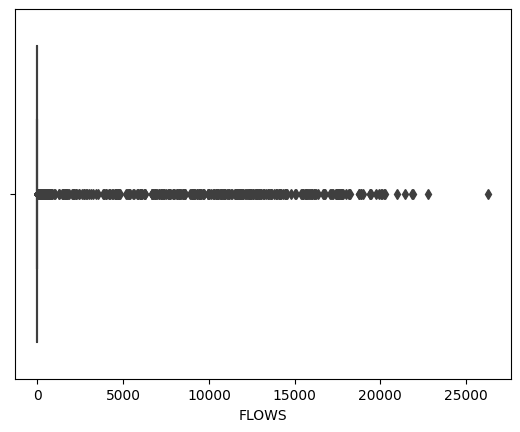

In [ ]:
sns.boxplot(x=OD_final["FLOWS"])

In [ ]:
# Calculate statistics for the "FLOWS" column
statistics = {
    'N': OD_final['FLOWS'].count(),
    'mean': OD_final['FLOWS'].mean(),
    'minimum': OD_final['FLOWS'].min(),
    'maximum': OD_final['FLOWS'].max(),
    'std_deviation': OD_final['FLOWS'].std(),
    'variance': OD_final['FLOWS'].var()
}

# Create a new DataFrame from the statistics dictionary
statistics_df = pd.DataFrame(statistics, index=['FLOWS'])
statistics_df

,N,mean,minimum,maximum,std_deviation,variance
FLOWS,172225,26.717166,0.0,26296.0,515.60277,265846.216659


In [ ]:
OD_final.to_csv(path + 'OD_level7_work_new.csv', index=False)

# **Destinations**

In [ ]:
OD_subset = OD_final.copy()

In [ ]:
OD_subset.drop(columns=['ORIGIN_CODE'], inplace=True)

In [ ]:
OD_subset

,DESTINATION_CODE,FLOWS
0,87194ac00ffffff,7405.0
1,87194ac01ffffff,42.0
2,87194ac02ffffff,42.0
3,87194ac03ffffff,21.0
4,87194ac04ffffff,42.0
...,...,...
172220,87195db5bffffff,0.0
172221,87195db5cffffff,0.0
172222,87195db5dffffff,0.0
172223,87195db69ffffff,21.0


In [ ]:
# Grouping by 'DESTINATION_CODE' and summing the 'FLOWS' column
OD_subset = OD_subset.groupby('DESTINATION_CODE')['FLOWS'].sum().reset_index()

In [ ]:
OD_subset= OD_subset.rename(columns={'DESTINATION_CODE': '_index'})

In [ ]:
OD_subset['FLOWS'] = OD_subset['FLOWS'].astype(int)

In [ ]:
OD_subset

,_index,FLOWS
0,87194ac00ffffff,9003
1,87194ac01ffffff,5420
2,87194ac02ffffff,4404
3,87194ac03ffffff,4203
4,87194ac04ffffff,9962
...,...,...
410,87195db5bffffff,7365
411,87195db5cffffff,105
412,87195db5dffffff,84
413,87195db69ffffff,1483


In [ ]:
LDN = grid8

In [ ]:
LDN

,_index,geometry,Centroids
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310)
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811)
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736)
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971)
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092)
...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377)
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413)
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499)
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204)


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
LDN_final = pd.merge(LDN, OD_subset, on= '_index', how= 'left')

In [ ]:
LDN_final

,_index,geometry,Centroids,FLOWS
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310),9003
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811),5420
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736),4404
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971),4203
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092),9962
...,...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377),7365
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413),105
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499),84
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204),1483


# **POI**

In [10]:
#Points of Interest - London
POI = gpd.read_file(path + 'a0000000a.gdbtable', crs='epsg:4326')

In [11]:
POI_LC = POI.copy()

In [12]:
# pick the columns that we need
POI_LC = POI_LC.loc[:,['groupname', 'geometry']]
POI_LC.columns

Index(['groupname', 'geometry'], dtype='object')

In [ ]:
POI_LC

,groupname,geometry
0,Transport,POINT (559498.000 184352.000)
1,Attractions,POINT (531404.000 196330.000)
2,Attractions,POINT (524417.000 197646.000)
3,Attractions,POINT (525419.000 189921.000)
4,Transport,POINT (537731.000 196190.000)
...,...,...
342381,Public Infrastructure,POINT (522497.500 192819.000)
342382,Public Infrastructure,POINT (543777.000 184393.000)
342383,Public Infrastructure,POINT (508075.000 186144.000)
342384,Public Infrastructure,POINT (517119.200 177291.200)


In [ ]:
# Spatial join the points to the polygons
POIHEX = gpd.sjoin(POI_LC, LDN, how='left', op='within')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
POIHEX

,groupname,geometry,index_right,_index,Centroids
0,Transport,POINT (559498.000 184352.000),181,87194e609ffffff,POINT (560279.301 183735.043)
1,Attractions,POINT (531404.000 196330.000),403,87195db4bffffff,POINT (532017.262 195382.750)
2,Attractions,POINT (524417.000 197646.000),409,87195db5affffff,POINT (524569.362 198778.796)
3,Attractions,POINT (525419.000 189921.000),307,87195da44ffffff,POINT (526040.981 190657.222)
4,Transport,POINT (537731.000 196190.000),241,87194e6b0ffffff,POINT (538723.708 196046.457)
...,...,...,...,...,...
342381,Public Infrastructure,POINT (522497.500 192819.000),348,87195da73ffffff,POINT (522314.675 192355.238)
342382,Public Infrastructure,POINT (543777.000 184393.000),210,87194e688ffffff,POINT (543169.627 184093.047)
342383,Public Infrastructure,POINT (508075.000 186144.000),356,87195dac2ffffff,POINT (507357.928 186733.804)
342384,Public Infrastructure,POINT (517119.200 177291.200),170,87194adb3ffffff,POINT (517046.263 177347.269)


In [ ]:
# Reset the index to have the points indexed by the polygons' index
POIHEX = POIHEX.reset_index(drop=True)

#  drop columns

LeisureCare = POIHEX.drop(['index_right'], axis=1)

LeisureCare

,groupname,geometry,_index,Centroids
0,Transport,POINT (559498.000 184352.000),87194e609ffffff,POINT (560279.301 183735.043)
1,Attractions,POINT (531404.000 196330.000),87195db4bffffff,POINT (532017.262 195382.750)
2,Attractions,POINT (524417.000 197646.000),87195db5affffff,POINT (524569.362 198778.796)
3,Attractions,POINT (525419.000 189921.000),87195da44ffffff,POINT (526040.981 190657.222)
4,Transport,POINT (537731.000 196190.000),87194e6b0ffffff,POINT (538723.708 196046.457)
...,...,...,...,...
342381,Public Infrastructure,POINT (522497.500 192819.000),87195da73ffffff,POINT (522314.675 192355.238)
342382,Public Infrastructure,POINT (543777.000 184393.000),87194e688ffffff,POINT (543169.627 184093.047)
342383,Public Infrastructure,POINT (508075.000 186144.000),87195dac2ffffff,POINT (507357.928 186733.804)
342384,Public Infrastructure,POINT (517119.200 177291.200),87194adb3ffffff,POINT (517046.263 177347.269)


In [ ]:
#  drop columns

df_LeisureCare = LeisureCare.drop(['geometry'], axis=1)

# Pivot the DataFrame
df_LeisureCare = df_LeisureCare.pivot_table(index='_index', columns='groupname', aggfunc='size', fill_value=0)

#  drop columns

# df_LeisureCare = df_LeisureCare.drop(['Manufacturing and Production', 'Public Infrastructure', 'Transport','Commercial Services'], axis=1)

# Set '_index' as the first column
df_LeisureCare.reset_index(inplace=True)

df_LeisureCare

groupname,_index,"Accommodation, Eating and Drinking",Attractions,Commercial Services,Education and Health,Manufacturing and Production,Public Infrastructure,Retail,Sport and Entertainment,Transport
0,87194ac00ffffff,51,9,193,66,34,115,69,24,87
1,87194ac01ffffff,12,12,75,26,4,56,11,6,51
2,87194ac02ffffff,9,4,61,10,9,38,13,11,46
3,87194ac03ffffff,4,16,21,5,4,37,7,5,43
4,87194ac04ffffff,54,11,180,79,14,119,56,31,74
...,...,...,...,...,...,...,...,...,...,...
397,87195db5bffffff,42,11,171,50,23,87,40,21,81
398,87195db5cffffff,0,0,0,1,0,7,0,0,2
399,87195db5dffffff,1,1,9,1,4,13,5,2,9
400,87195db69ffffff,1,1,7,0,7,11,5,0,13


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
features = pd.merge(OD_subset, df_LeisureCare, on= '_index', how= 'left').fillna(0)
features

,_index,FLOWS,"Accommodation, Eating and Drinking",Attractions,Commercial Services,Education and Health,Manufacturing and Production,Public Infrastructure,Retail,Sport and Entertainment,Transport
0,87194ac00ffffff,9003,51.0,9.0,193.0,66.0,34.0,115.0,69.0,24.0,87.0
1,87194ac01ffffff,5420,12.0,12.0,75.0,26.0,4.0,56.0,11.0,6.0,51.0
2,87194ac02ffffff,4404,9.0,4.0,61.0,10.0,9.0,38.0,13.0,11.0,46.0
3,87194ac03ffffff,4203,4.0,16.0,21.0,5.0,4.0,37.0,7.0,5.0,43.0
4,87194ac04ffffff,9962,54.0,11.0,180.0,79.0,14.0,119.0,56.0,31.0,74.0
...,...,...,...,...,...,...,...,...,...,...,...
410,87195db5bffffff,7365,42.0,11.0,171.0,50.0,23.0,87.0,40.0,21.0,81.0
411,87195db5cffffff,105,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,2.0
412,87195db5dffffff,84,1.0,1.0,9.0,1.0,4.0,13.0,5.0,2.0,9.0
413,87195db69ffffff,1483,1.0,1.0,7.0,0.0,7.0,11.0,5.0,0.0,13.0


In [ ]:
# Rename Columns

features = features.rename(columns={
                          'Accommodation, Eating and Drinking' : 'AED',
                          'Attractions' : 'AT',
                          'Commercial Services' : 'CS',
                          'Education and Health' : 'EH',
                          'Manufacturing and Production' : 'MP',
                          'Public Infrastructure' : 'PI',
                          'Retail' : 'RT',
                          'Sport and Entertainment' : 'SE',
                          'Transport' : 'TR',
                          })

In [ ]:
# Columns to convert from float to integer
columns_to_convert = ['AED', 'AT', 'CS', 'EH', 'MP', 'PI', 'RT', 'SE', 'TR']

# Loop through the columns and convert their data types
for col in columns_to_convert:
    features[col] = features[col].astype(int)


In [ ]:
#  drop columns

POI_work = features.drop(['AED', 'CS', 'AT', 'RT', 'SE', 'MP'], axis=1)

In [ ]:
# List of columns to be summed
columns_to_sum = ['EH', 'PI', 'TR']

# Create the new column 'all' by summing the values of the specified columns
POI_work['all'] = POI_work[columns_to_sum].sum(axis=1)


# Move the 'all' column to position 1
all_column = POI_work.pop('all')
POI_work.insert(1, 'all', all_column)

In [ ]:
#  drop columns

POI_work = POI_work.drop(['FLOWS', 'EH', 'PI', 'TR'], axis=1)

In [ ]:
POI_work

,_index,all
0,87194ac00ffffff,268
1,87194ac01ffffff,133
2,87194ac02ffffff,94
3,87194ac03ffffff,85
4,87194ac04ffffff,272
...,...,...
410,87195db5bffffff,218
411,87195db5cffffff,10
412,87195db5dffffff,23
413,87195db69ffffff,24


In [ ]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
LDN_final = pd.merge(LDN_final, POI_work, on= '_index', how= 'left')

In [ ]:
LDN_final

,_index,geometry,Centroids,FLOWS,all
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310),9003,268
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811),5420,133
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736),4404,94
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971),4203,85
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092),9962,272
...,...,...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377),7365,218
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413),105,10
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499),84,23
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204),1483,24


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(LDN_final, *['FLOWS'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(LDN_final, *['all'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(LDN_final, *['FLOWS'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(LDN_final, *['all'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(LDN_final, *[[['FLOWS', 'all']]], **{})
chart

In [ ]:
#set

#setup the font
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

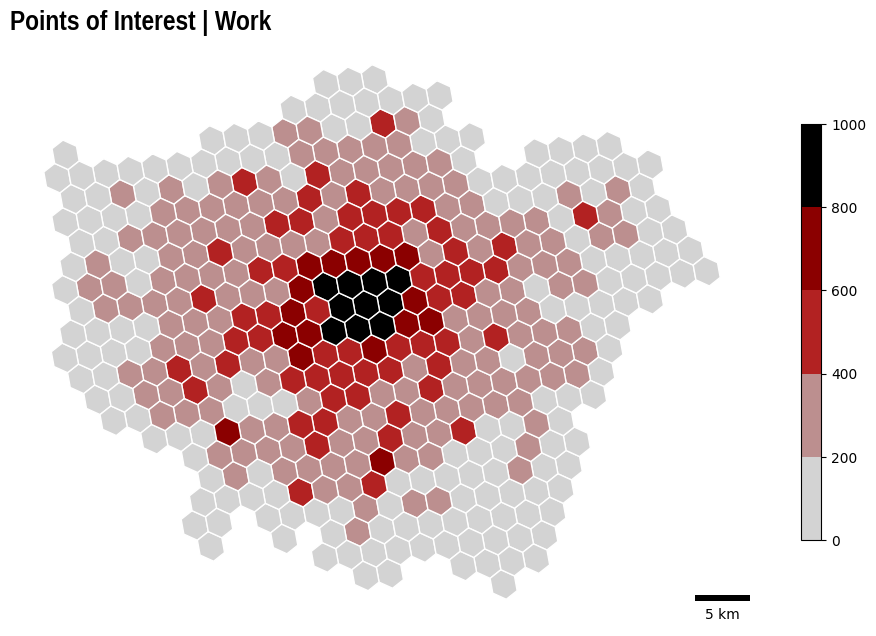

In [ ]:
#transform london to BNG
LDN_final.to_crs("EPSG:27700", inplace = True)

# plot
fig, ax = plt.subplots(1,1, figsize=(12,9))

# scalebar
divider = make_axes_locatable(ax)
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# create discrete colormap
cmap = colors.ListedColormap(['lightgrey', 'rosybrown', 'firebrick', 'darkred',  'black'])
bounds = [0,200,400,600,800,1000]
norm = colors.BoundaryNorm(bounds, cmap.N)

#We can check that this has occured by plotting the results
LDN_final.plot(ax=ax, column='all', cmap=cmap, norm=norm, legend=True,edgecolor='white',legend_kwds={'shrink': 0.6})


plt.axis('off')
plt.title("Points of Interest | Work", loc='left', size=20,**tfont)
plt.savefig(path + "images/POI_work.png", bbox_inches = 'tight')

In [ ]:
POI_work.to_csv(path + 'POI_work7_new.csv', index=False)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
 2   AED     415 non-null    int64 
 3   AT      415 non-null    int64 
 4   CS      415 non-null    int64 
 5   EH      415 non-null    int64 
 6   MP      415 non-null    int64 
 7   PI      415 non-null    int64 
 8   RT      415 non-null    int64 
 9   SE      415 non-null    int64 
 10  TR      415 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 38.9+ KB


# **DG_Features**

**Load packages and data**

In [40]:
df = POI.copy()

# locomizer hexagon grid at level 7
LDN = gpd.read_file(path + 'grid7.json')

In [41]:
# pick the columns that we need
POI = df.loc[:,['groupname','categoryname','classname', 'geometry']]
POI.columns

Index(['groupname', 'categoryname', 'classname', 'geometry'], dtype='object')

In [42]:
POI = POI[POI['groupname'] != 'Manufacturing and Production']

**1. TRANSPORT[4]**

0.   Bus Transport [categoryname]
1.   Public Transport, Stations and Infrastructure [categoryname]
2.   'Water' [categoryname]
3.   'Air' [categoryname]

In [43]:
# TRANSPORT

#remove categoryname not utilised
POI = POI[POI['categoryname'] != 'Road and Rail']
POI = POI[POI['categoryname'] != 'Walking']



In [44]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Bus Transport': '0_Bus',
    'Public Transport, Stations and Infrastructure': '1_Stations_Infrastructure',
    'Water': '2_Water',
    'Air': '3_Air'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and return the corresponding 'new definition'
def check_category(row):
    for substring, definition in category_mapping.items():
        if substring in row['categoryname']:
            return definition
    return ''

# Apply the function to create the 'features' column
POI['features'] = POI.apply(check_category, axis=1)

In [45]:
POI['features'].unique().tolist()

['0_Bus', '', '2_Water', '1_Stations_Infrastructure', '3_Air']

**2_EDUCATION AND HEALTH[2]**
4.  Education [new]
5.  Health [new]

In [46]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Recreational and Vocational Education': '4_Education',
    'Primary, Secondary and Tertiary Education': '4_Education',
    'Education Support Services': '4_Education',
    'Health Support Services': '5_Health',
    'Health Practitioners and Establishments': '5_Health',
    'Animal Welfare': '5_Health'

    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['categoryname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [47]:
POI['features'].unique().tolist()

['0_Bus',
 '',
 '5_Health',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '3_Air']

**3_Accommodation, Eating and Drinking[5]**
6.   Accomodation [new]
7.   Restaurants [classname]
8.   Fast Food [new]
9.  Pubs, Bars and Inns [classname]
10.  Cafes, Snack Bars and Tea Rooms [new]

In [48]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Banqueting and Function Rooms': '6_Accomodation',
    'Camping, Caravanning, Mobile Homes, Holiday Parks and Centres': '6_Accomodation',
    'Hostels and Refuges For The Homeless': '6_Accomodation',
    'Bed and Breakfast and Backpacker Accommodation': '6_Accomodation',
    'Youth Accommodation': '6_Accomodation',
    'Self Catering': '6_Accomodation',
    'Hotels, Motels, Country Houses and Inns': '6_Accomodation',
    'Timeshare': '6_Accomodation',
    'Restaurants': '7_Restaurants',
    'Fast Food and Takeaway Outlets': '8_Fast_Food',
    'Fish and Chip Shops': '8_Fast_Food',
    'Fast Food Delivery Services': '8_Fast_Food',
    'Pubs, Bars and Inns': '9_Pubs',
    'Cafes, Snack Bars and Tea Rooms': '10_Cafes',
    'Internet Cafes': '10_Cafes'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['classname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [49]:
POI['features'].unique().tolist()

['0_Bus',
 '',
 '5_Health',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '9_Pubs',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**4_RETAIL AND SERVICES[2]**

11.  Retail[groupname]
12.  Commercial Services [groupname]

In [50]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Retail': '11_Retail',
    'Commercial Services': '12_Commercial_Services'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['groupname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)


In [51]:
POI['features'].unique().tolist()

['0_Bus',
 '',
 '5_Health',
 '12_Commercial_Services',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '11_Retail',
 '9_Pubs',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**5_LEISURE[2]**
13.  Sport and Entertainment[groupname]
14.  Atractions [groupname]

In [52]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Sport and Entertainment': '13_Sport_Entertainment',
    'Attractions': '14_Attractions'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['groupname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [53]:
POI['features'].unique().tolist()

['0_Bus',
 '14_Attractions',
 '5_Health',
 '12_Commercial_Services',
 '',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '2_Water',
 '1_Stations_Infrastructure',
 '11_Retail',
 '9_Pubs',
 '13_Sport_Entertainment',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**6_PUBLIC INFRASTRUCTURE[3]**
15. Infrastructure and Facilities [categoryname]
16. Central and Local Government [categoryname]
17. Organisations [categoryname]

In [54]:
# Define the mapping of substrings to 'new definition' in a dictionary
category_mapping = {
    'Infrastructure and Facilities': '15_Facilities',
    'Central and Local Government': '16_Government',
    'Organisations': '17_Organisations'
    # Add more mappings as needed
}

# Define a function to check if any of the substrings are present in the 'categoryname'
# and update the 'features' column accordingly
def update_features(row):
    for substring, definition in category_mapping.items():
        if substring in row['categoryname']:
            return definition
    return row['features']

# Apply the function to update the 'features' column
POI['features'] = POI.apply(update_features, axis=1)

In [55]:
POI['features'].unique().tolist()

['0_Bus',
 '14_Attractions',
 '5_Health',
 '12_Commercial_Services',
 '15_Facilities',
 '7_Restaurants',
 '6_Accomodation',
 '4_Education',
 '16_Government',
 '17_Organisations',
 '2_Water',
 '1_Stations_Infrastructure',
 '11_Retail',
 '9_Pubs',
 '13_Sport_Entertainment',
 '10_Cafes',
 '8_Fast_Food',
 '3_Air']

**Merge data**

In [56]:
POI

,groupname,categoryname,classname,geometry,features
0,Transport,Bus Transport,Bus Stops,POINT (559498.000 184352.000),0_Bus
1,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (531404.000 196330.000),14_Attractions
2,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (524417.000 197646.000),14_Attractions
3,Attractions,Historical and Cultural,Historic and Ceremonial Structures,POINT (525419.000 189921.000),14_Attractions
4,Transport,Bus Transport,Bus Stops,POINT (537731.000 196190.000),0_Bus
...,...,...,...,...,...
342381,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,POINT (522497.500 192819.000),15_Facilities
342382,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,POINT (543777.000 184393.000),15_Facilities
342383,Public Infrastructure,Organisations,Youth Organisations,POINT (508075.000 186144.000),17_Organisations
342384,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,POINT (517119.200 177291.200),15_Facilities


In [57]:
# pick the columns that we need
POI_features = POI.loc[:,['features', 'geometry']]
POI_features.columns

Index(['features', 'geometry'], dtype='object')

In [58]:
LDN = grid8

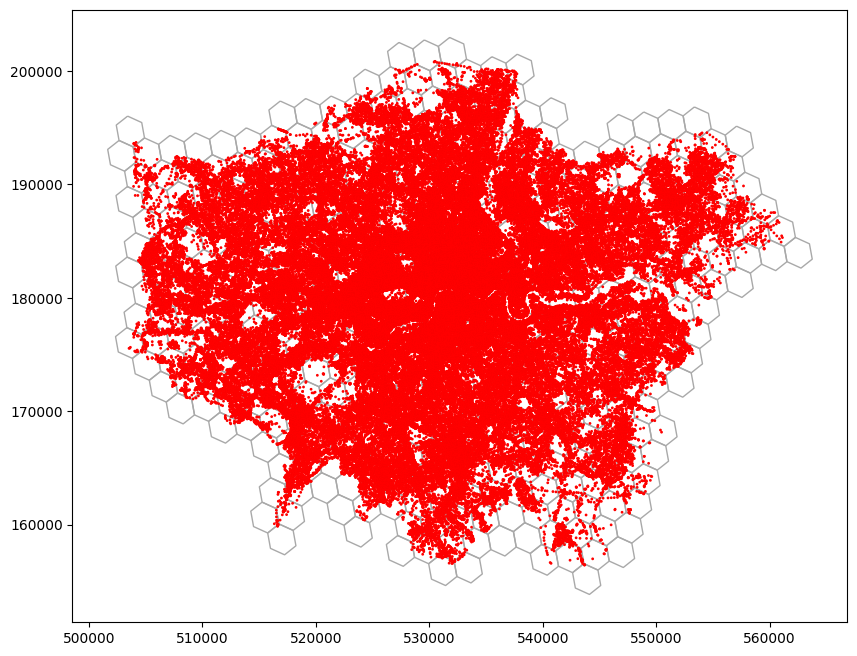

In [59]:
fig, ax = plt.subplots(1,1, figsize=(10,15))

#transform london to BNG
POI_features.to_crs("EPSG:27700", inplace = True)
LDN.to_crs("EPSG:27700", inplace = True)

#We can check that this has occured by plotting the results
LDN.plot(facecolor = "None", edgecolor = "darkgray", ax=ax)
POI_features.plot(cmap='Greens', markersize=1, facecolor = "None", edgecolor = "r", ax=ax)

plt.show()

In [60]:
# Spatial join the points to the polygons
POI_features = gpd.sjoin(POI_features, LDN, how='inner', op='within')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [61]:
# Reset the index to have the points indexed by the polygons' index
POI_features = POI_features.reset_index(drop=True)

In [62]:
POI_features

,features,geometry,index_right,_index,Centroids
0,0_Bus,POINT (559498.000 184352.000),181,87194e609ffffff,POINT (560279.301 183735.043)
1,0_Bus,POINT (559508.000 184343.000),181,87194e609ffffff,POINT (560279.301 183735.043)
2,13_Sport_Entertainment,POINT (559923.900 184982.000),181,87194e609ffffff,POINT (560279.301 183735.043)
3,11_Retail,POINT (559923.900 184982.000),181,87194e609ffffff,POINT (560279.301 183735.043)
4,12_Commercial_Services,POINT (559505.000 184295.000),181,87194e609ffffff,POINT (560279.301 183735.043)
...,...,...,...,...,...
318600,15_Facilities,POINT (503967.600 192350.400),352,87195da89ffffff,POINT (502890.015 192500.583)
318601,15_Facilities,POINT (504064.200 192322.700),352,87195da89ffffff,POINT (502890.015 192500.583)
318602,15_Facilities,POINT (556364.600 193062.900),178,87194e604ffffff,POINT (557317.982 193760.717)
318603,15_Facilities,POINT (556355.600 193060.300),178,87194e604ffffff,POINT (557317.982 193760.717)


In [63]:
#  drop columns

POI_features = POI_features.drop(['geometry', 'index_right'], axis=1)

# Pivot the DataFrame
POI_features = POI_features.pivot_table(index='_index', columns='features', aggfunc='size', fill_value=0)

# Set '_index' as the first column
POI_features.reset_index(inplace=True)



In [64]:
POI_features.columns

Index(['_index', '0_Bus', '10_Cafes', '11_Retail', '12_Commercial_Services',
       '13_Sport_Entertainment', '14_Attractions', '15_Facilities',
       '16_Government', '17_Organisations', '1_Stations_Infrastructure',
       '2_Water', '3_Air', '4_Education', '5_Health', '6_Accomodation',
       '7_Restaurants', '8_Fast_Food', '9_Pubs'],
      dtype='object', name='features')

In [65]:
POI_features

features,_index,0_Bus,10_Cafes,11_Retail,12_Commercial_Services,13_Sport_Entertainment,14_Attractions,15_Facilities,16_Government,17_Organisations,1_Stations_Infrastructure,2_Water,3_Air,4_Education,5_Health,6_Accomodation,7_Restaurants,8_Fast_Food,9_Pubs
0,87194ac00ffffff,66,15,69,193,24,9,106,2,7,2,0,0,27,39,2,12,21,1
1,87194ac01ffffff,50,2,11,75,6,12,53,1,2,0,0,0,12,14,0,2,5,3
2,87194ac02ffffff,43,2,13,61,11,4,37,0,1,1,0,0,4,6,1,0,4,2
3,87194ac03ffffff,32,4,7,21,5,16,34,3,0,1,0,0,1,4,0,0,0,0
4,87194ac04ffffff,55,9,56,180,31,11,107,2,10,1,0,1,24,55,3,16,18,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,87195db5bffffff,48,9,40,171,21,11,77,3,7,1,1,0,21,29,1,10,18,4
397,87195db5cffffff,1,0,0,0,0,0,7,0,0,0,0,0,1,0,0,0,0,0
398,87195db5dffffff,8,0,5,9,2,1,11,1,1,0,0,0,1,0,0,0,0,1
399,87195db69ffffff,0,1,5,7,0,1,9,1,1,0,3,0,0,0,0,0,0,0


In [66]:
pop = pd.read_csv( path + 'pop7.csv')

In [69]:
# Merge the dataframes based on the index ['ORIGIN_CODE', 'DESTINATION_CODE']
POI_features = pd.merge(pop, POI_features, on=['_index'], how= 'left').fillna(0)
POI_features = POI_features.drop(['population'], axis=1)
POI_features

,_index,0_Bus,10_Cafes,11_Retail,12_Commercial_Services,13_Sport_Entertainment,14_Attractions,15_Facilities,16_Government,17_Organisations,1_Stations_Infrastructure,2_Water,3_Air,4_Education,5_Health,6_Accomodation,7_Restaurants,8_Fast_Food,9_Pubs
0,87194ac00ffffff,66.0,15.0,69.0,193.0,24.0,9.0,106.0,2.0,7.0,2.0,0.0,0.0,27.0,39.0,2.0,12.0,21.0,1.0
1,87194ac01ffffff,50.0,2.0,11.0,75.0,6.0,12.0,53.0,1.0,2.0,0.0,0.0,0.0,12.0,14.0,0.0,2.0,5.0,3.0
2,87194ac02ffffff,43.0,2.0,13.0,61.0,11.0,4.0,37.0,0.0,1.0,1.0,0.0,0.0,4.0,6.0,1.0,0.0,4.0,2.0
3,87194ac03ffffff,32.0,4.0,7.0,21.0,5.0,16.0,34.0,3.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0
4,87194ac04ffffff,55.0,9.0,56.0,180.0,31.0,11.0,107.0,2.0,10.0,1.0,0.0,1.0,24.0,55.0,3.0,16.0,18.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,87195db5bffffff,48.0,9.0,40.0,171.0,21.0,11.0,77.0,3.0,7.0,1.0,1.0,0.0,21.0,29.0,1.0,10.0,18.0,4.0
411,87195db5cffffff,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
412,87195db5dffffff,8.0,0.0,5.0,9.0,2.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
413,87195db69ffffff,0.0,1.0,5.0,7.0,0.0,1.0,9.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# Rename Columns

POI_features = POI_features.rename(columns={
                          '0_Bus' : '0',
                          '1_Stations_Infrastructure' : '1',
                          '2_Water' : '2',
                          '3_Air' : '3',
                          '4_Education' : '4',
                          '5_Health' : '5',
                          '6_Accomodation' : '6',
                          '7_Restaurants' : '7',
                          '8_Fast_Food' : '8',
                          '9_Pubs' : '9',
                          '10_Cafes' : '10',
                          '11_Retail' : '11',
                          '12_Commercial_Services' : '12',
                          '13_Sport_Entertainment' : '13',
                          '14_Attractions' :'14',
                          '15_Facilities' : '15',
                          '16_Government' : '16',
                          '17_Organisations' : '17',
                          })

In [71]:
POI_features

,_index,0,10,11,12,13,14,15,16,17,1,2,3,4,5,6,7,8,9
0,87194ac00ffffff,66.0,15.0,69.0,193.0,24.0,9.0,106.0,2.0,7.0,2.0,0.0,0.0,27.0,39.0,2.0,12.0,21.0,1.0
1,87194ac01ffffff,50.0,2.0,11.0,75.0,6.0,12.0,53.0,1.0,2.0,0.0,0.0,0.0,12.0,14.0,0.0,2.0,5.0,3.0
2,87194ac02ffffff,43.0,2.0,13.0,61.0,11.0,4.0,37.0,0.0,1.0,1.0,0.0,0.0,4.0,6.0,1.0,0.0,4.0,2.0
3,87194ac03ffffff,32.0,4.0,7.0,21.0,5.0,16.0,34.0,3.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0
4,87194ac04ffffff,55.0,9.0,56.0,180.0,31.0,11.0,107.0,2.0,10.0,1.0,0.0,1.0,24.0,55.0,3.0,16.0,18.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,87195db5bffffff,48.0,9.0,40.0,171.0,21.0,11.0,77.0,3.0,7.0,1.0,1.0,0.0,21.0,29.0,1.0,10.0,18.0,4.0
411,87195db5cffffff,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
412,87195db5dffffff,8.0,0.0,5.0,9.0,2.0,1.0,11.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
413,87195db69ffffff,0.0,1.0,5.0,7.0,0.0,1.0,9.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Get the column names that are numeric, excluding '_index'
numeric_columns = [col for col in POI_features.columns if col != '_index' and col.isdigit()]

# Sort the numeric columns in numerical order
numeric_columns.sort(key=int)

# Reorder the columns with '_index' at position 0 followed by the sorted numeric columns
new_column_order = ['_index'] + numeric_columns

# Update the DataFrame with the new column order
POI_features = POI_features[new_column_order]


In [73]:
POI_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   _index  415 non-null    object 
 1   0       415 non-null    float64
 2   1       415 non-null    float64
 3   2       415 non-null    float64
 4   3       415 non-null    float64
 5   4       415 non-null    float64
 6   5       415 non-null    float64
 7   6       415 non-null    float64
 8   7       415 non-null    float64
 9   8       415 non-null    float64
 10  9       415 non-null    float64
 11  10      415 non-null    float64
 12  11      415 non-null    float64
 13  12      415 non-null    float64
 14  13      415 non-null    float64
 15  14      415 non-null    float64
 16  15      415 non-null    float64
 17  16      415 non-null    float64
 18  17      415 non-null    float64
dtypes: float64(18), object(1)
memory usage: 64.8+ KB


In [74]:
POI_features

,_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,87194ac00ffffff,66.0,2.0,0.0,0.0,27.0,39.0,2.0,12.0,21.0,1.0,15.0,69.0,193.0,24.0,9.0,106.0,2.0,7.0
1,87194ac01ffffff,50.0,0.0,0.0,0.0,12.0,14.0,0.0,2.0,5.0,3.0,2.0,11.0,75.0,6.0,12.0,53.0,1.0,2.0
2,87194ac02ffffff,43.0,1.0,0.0,0.0,4.0,6.0,1.0,0.0,4.0,2.0,2.0,13.0,61.0,11.0,4.0,37.0,0.0,1.0
3,87194ac03ffffff,32.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,7.0,21.0,5.0,16.0,34.0,3.0,0.0
4,87194ac04ffffff,55.0,1.0,0.0,1.0,24.0,55.0,3.0,16.0,18.0,8.0,9.0,56.0,180.0,31.0,11.0,107.0,2.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,87195db5bffffff,48.0,1.0,1.0,0.0,21.0,29.0,1.0,10.0,18.0,4.0,9.0,40.0,171.0,21.0,11.0,77.0,3.0,7.0
411,87195db5cffffff,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
412,87195db5dffffff,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,9.0,2.0,1.0,11.0,1.0,1.0
413,87195db69ffffff,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,7.0,0.0,1.0,9.0,1.0,1.0


In [75]:
POI_features.to_csv(path + 'features.csv', index=True)

# **Sanity Check**

In [ ]:
LDN_final

,_index,geometry,Centroids,FLOWS
0,87194ac00ffffff,"POLYGON ((530198.675 161408.835, 529201.343 16...",POINT (530444.193 160052.310),9003
1,87194ac01ffffff,"POLYGON ((531687.078 159487.402, 530689.887 15...",POINT (531932.646 158130.811),5420
2,87194ac02ffffff,"POLYGON ((527958.284 161182.457, 526960.606 16...",POINT (528203.746 159825.736),4404
3,87194ac03ffffff,"POLYGON ((529446.920 159260.759, 528449.383 15...",POINT (529692.431 157903.971),4203
4,87194ac04ffffff,"POLYGON ((530950.217 163556.354, 529953.090 16...",POINT (531195.743 162200.092),9962
...,...,...,...,...
410,87195db5bffffff,"POLYGON ((525811.072 198212.705, 524814.675 19...",POINT (526056.262 196859.377),7365
411,87195db5cffffff,"POLYGON ((527312.727 202492.207, 526316.744 20...",POINT (527557.932 201139.413),105
412,87195db5dffffff,"POLYGON ((528799.155 200573.363, 527803.312 19...",POINT (529044.412 199220.499),84
413,87195db69ffffff,"POLYGON ((537741.407 201455.283, 536746.951 20...",POINT (537986.901 200103.204),1483


In [ ]:
#set

#setup the font
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

#setup north arrow
im=img.imread(path + 'north_arrow.png')
imagebox = OffsetImage(im,zoom=1.5)
ab = AnnotationBbox(imagebox, (515583,-7112))

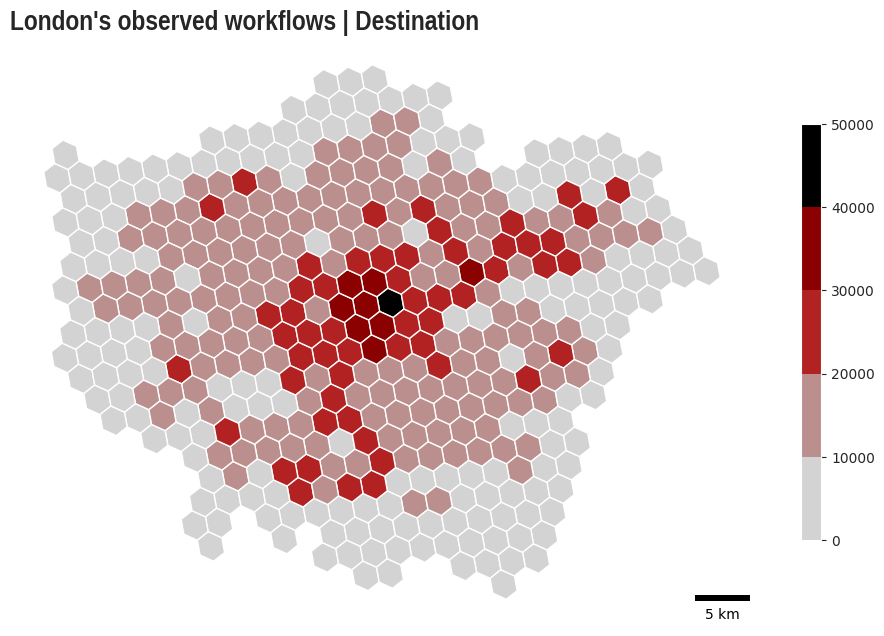

In [ ]:
#transform london to BNG
LDN_final.to_crs("EPSG:27700", inplace = True)

# plot
fig, ax = plt.subplots(1,1, figsize=(12,9))

# scalebar
divider = make_axes_locatable(ax)
scalebar = ScaleBar(1, location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# create discrete colormap
cmap = colors.ListedColormap(['lightgrey', 'rosybrown', 'firebrick', 'darkred',  'black'])
bounds = [0,10000,20000,30000,40000,50000]
norm = colors.BoundaryNorm(bounds, cmap.N)

#We can check that this has occured by plotting the results
LDN_final.plot(ax=ax, column='FLOWS', cmap=cmap, norm=norm, legend=True,edgecolor='white',legend_kwds={'shrink': 0.6})


plt.axis('off')
plt.title("London's observed workflows | Destination", loc='left', size=20,**tfont)
plt.savefig(path + "images/Hex_work_observed.png", bbox_inches = 'tight')

In [ ]:
flows = OD_final

In [ ]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.6+ KB


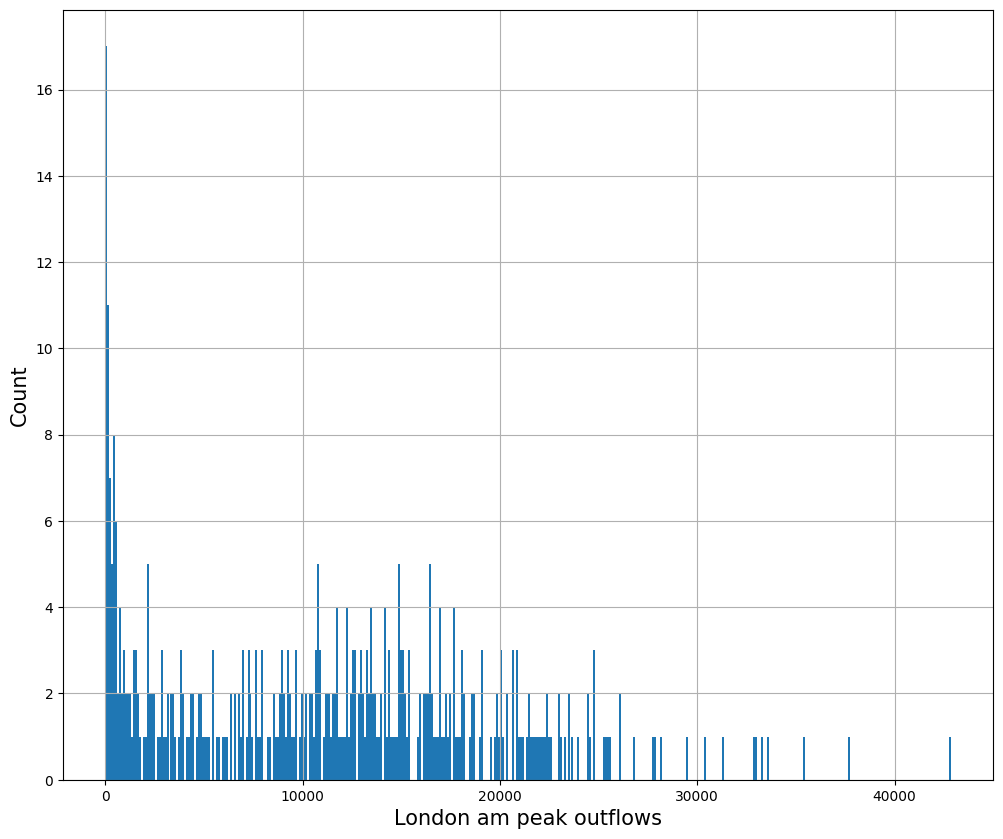

In [ ]:

# Assuming your DataFrame is named 'df' and the 'FLOWS' column is converted to integer data type
bin_size = 100

# Extract the 'FLOWS' column from the DataFrame
flows = flows['FLOWS']

# Create a histogram plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.hist(flows, bins=int(flows.max() / bin_size))
plt.xlabel('London am peak outflows', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(True)
plt.show()


<Axes: xlabel='FLOWS', ylabel='Count'>

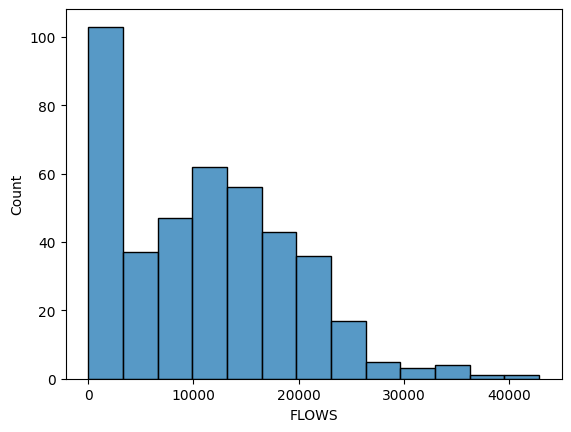

In [ ]:
# A normal plot
sns.histplot(data=OD_final, x="FLOWS")

In [ ]:
# Assuming OD_final is your DataFrame
new_data = OD_final[OD_final["FLOWS"] > 0]

In [ ]:
# Remove rows with zero values in the 'FLOWS' column
#new_data = new_data[new_data['FLOWS'] != 0]

In [ ]:
# Calculate statistics for the "FLOWS" column
statistics = {
    'N': new_data['FLOWS'].count(),
    'mean': new_data['FLOWS'].mean(),
    'minimum': new_data['FLOWS'].min(),
    'maximum': new_data['FLOWS'].max(),
    'std_deviation': new_data['FLOWS'].std(),
    'variance': new_data['FLOWS'].var()
}

# Create a new DataFrame from the statistics dictionary
statistics_df = pd.DataFrame(statistics, index=['FLOWS'])
statistics_df

,N,mean,minimum,maximum,std_deviation,variance
FLOWS,411,11195.532847,21,42846,8305.177361,6.897597e+07


<Axes: xlabel='FLOWS', ylabel='Count'>

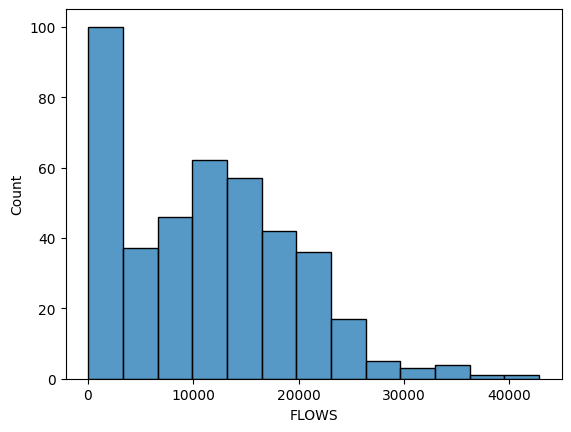

In [ ]:
# A normal plot
sns.histplot(data=new_data, x="FLOWS")

<Axes: xlabel='FLOWS', ylabel='Count'>

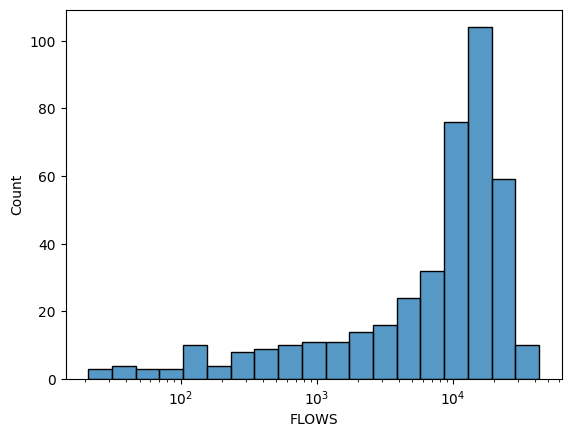

In [ ]:
# A plot with log values, for large datasets
sns.histplot(data=new_data, x="FLOWS", log_scale=True)


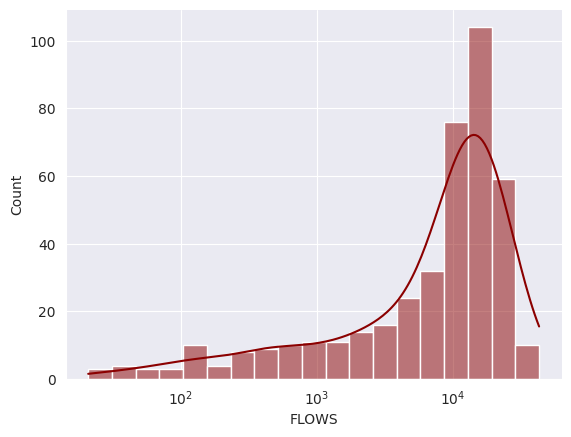

In [ ]:
#A plot whith a line to se the distribution
sns.set_style("darkgrid")
sns.histplot(data=new_data, x="FLOWS", kde=True, log_scale=True, color='darkred')
sns.despine()
plt.savefig(path + "images/histogram_work.png", dpi=300)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _index  415 non-null    object
 1   FLOWS   415 non-null    int64 
 2   AED     415 non-null    int64 
 3   AT      415 non-null    int64 
 4   CS      415 non-null    int64 
 5   EH      415 non-null    int64 
 6   MP      415 non-null    int64 
 7   PI      415 non-null    int64 
 8   RT      415 non-null    int64 
 9   SE      415 non-null    int64 
 10  TR      415 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 38.9+ KB


In [ ]:
# This performs a multiple regression of wellbeing against greenery:

school_pop = smf.ols(formula='FLOWS ~ AED + CS + AT + EH + MP + PI + RT + SE + TR',data=features).fit()

# And this gives a big summary of the results:
print(school_pop.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     287.0
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          1.11e-169
Time:                        11:41:23   Log-Likelihood:                -3920.5
No. Observations:                 415   AIC:                             7861.
Df Residuals:                     405   BIC:                             7901.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    915.7761    286.711      3.194      0.0

In [ ]:
# This performs a multiple regression of wellbeing against greenery:

school_pop = smf.ols(formula='FLOWS ~ AED + AT + EH + MP + PI + RT + TR',data=features).fit()

# And this gives a big summary of the results:
print(school_pop.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     365.1
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          4.62e-171
Time:                        15:16:02   Log-Likelihood:                -3923.3
No. Observations:                 415   AIC:                             7863.
Df Residuals:                     407   BIC:                             7895.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    932.6236    284.803      3.275      0.0

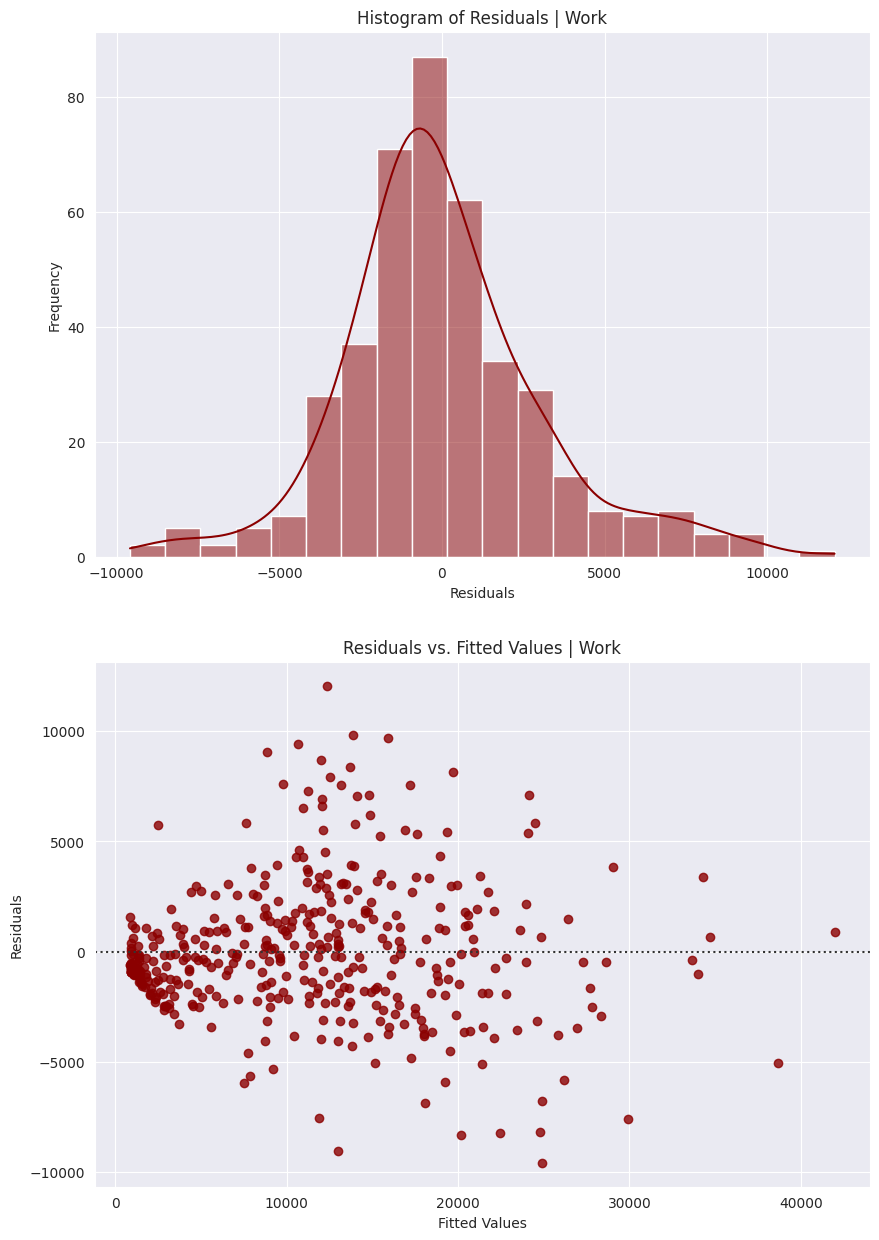

In [ ]:
# Get the residuals from your regression model
residuals = school_pop.resid

#plot
f = plt.figure(figsize=(10, 15))
gs = f.add_gridspec(2, 1)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.histplot(residuals, kde=True, color='darkred', bins=20)
    plt.title('Histogram of Residuals | Work')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1,0])
    sns.residplot(x=school_pop.fittedvalues, y=residuals, color='darkred')
    plt.title('Residuals vs. Fitted Values | Work')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

plt.savefig(path + "images/Residuals_work.png")

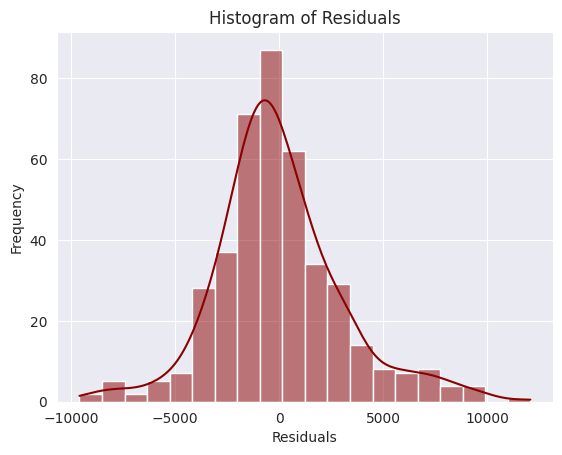

In [ ]:
# Get the residuals from your regression model
residuals = school_pop.resid

# Create a histogram of the residuals
plt.figure()
sns.histplot(residuals, kde=True, color='darkred', bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Residuals')

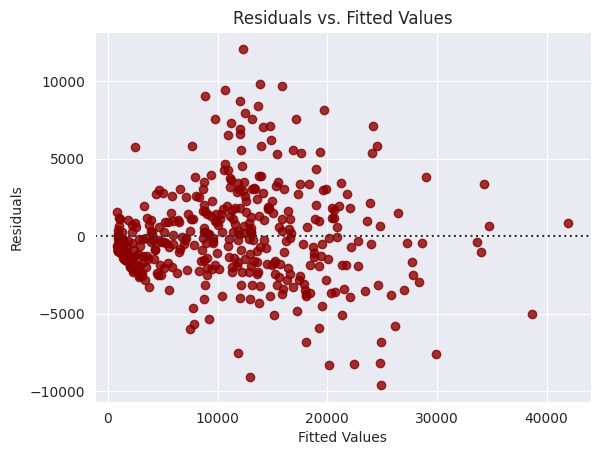

In [ ]:
sns.residplot(x=school_pop.fittedvalues, y=residuals, color='darkred')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

In [ ]:
test_ft = features

In [ ]:
#take the variables and produce logarithms of them
x_variables = ['AED', 'AT', 'EH', 'MP', 'PI', 'RT', 'TR']
log_x_vars = []
for x in x_variables:
    test_ft[f"log_{x}"] = np.log(test_ft[x]+1)
    log_x_vars.append(f"log_{x}")

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'FLOWS ~ log_AED + log_AT + log_EH + log_MP + log_PI + log_RT + log_TR'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=test_ft, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  FLOWS   No. Observations:                  415
Model:                            GLM   Df Residuals:                      407
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7146e+05
Date:                Fri, 01 Sep 2023   Deviance:                   3.3860e+05
Time:                        11:00:30   Pearson chi2:                 3.65e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4919      0.006    920.701      0.0

In [ ]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'FLOWS ~ log_EH + log_PI + log_TR'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=test_ft, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  FLOWS   No. Observations:                  415
Model:                            GLM   Df Residuals:                      411
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9455e+05
Date:                Fri, 01 Sep 2023   Deviance:                   3.8478e+05
Time:                        11:29:03   Pearson chi2:                 3.82e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1119      0.004   1530.195      0.0

In [ ]:
# This performs a multiple regression of wellbeing against greenery:

school_pop = smf.ols(formula='FLOWS ~ PI ',data=features).fit()

# And this gives a big summary of the results:
print(school_pop.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     1470.
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          3.90e-138
Time:                        11:00:30   Log-Likelihood:                -4020.4
No. Observations:                 415   AIC:                             8045.
Df Residuals:                     413   BIC:                             8053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2835.8327    288.363      9.834      0.0

In [ ]:
# Pick out some values of interest and print the regression equation: y=mx+c or y=beta_1*x + beta_0

# The order of results: intercept term, slope term
beta_0, beta_1 = school_pop.params
rsq    = school_pop.rsquared
pval_0, pval_1 = school_pop.pvalues

print("y =", round(beta_1,3), "x +", round(beta_0,3))
print("R^2 = ", rsq)
print("p-value of greenery = ", round(pval_1,5))
print("p-value of intercept = ", round(pval_0,5))

y = 71.192 x + 2835.833
R^2 =  0.7806528016479278
p-value of greenery =  0.0
p-value of intercept =  0.0


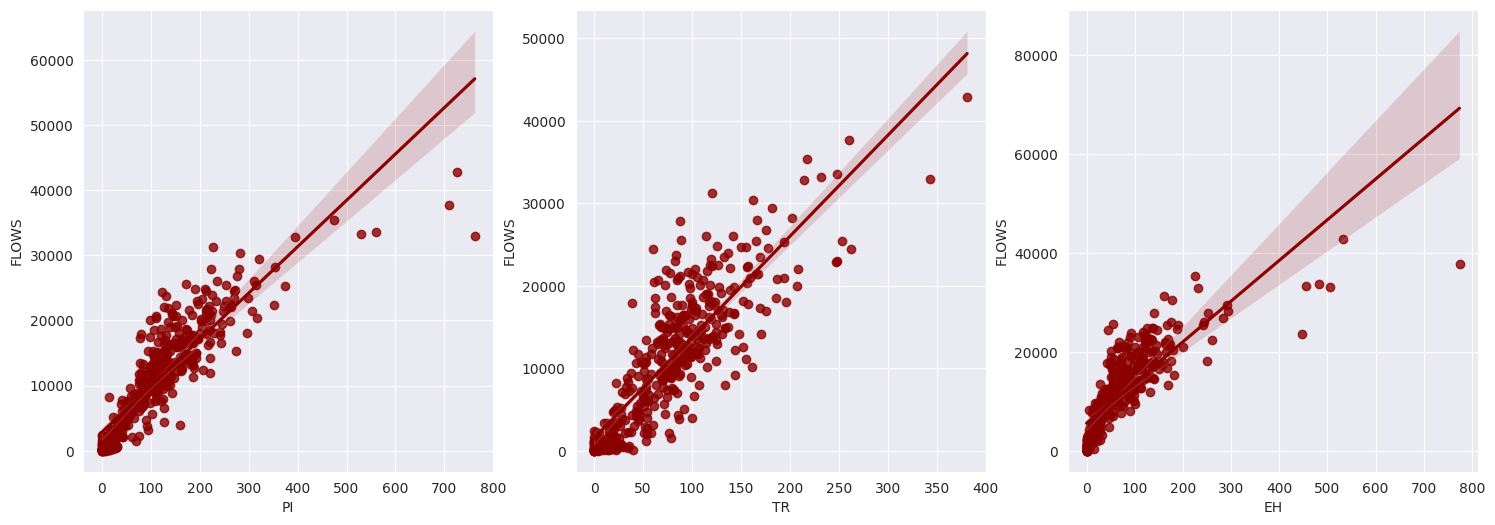

In [ ]:
f = plt.figure(figsize=(18, 6))
gs = f.add_gridspec(1, 3)

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.regplot(x="PI", y="FLOWS", data=features, color='darkred')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.regplot(x="TR", y="FLOWS", data=features, color='darkred')

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 2])
    sns.regplot(x="EH", y="FLOWS", data=features, color='darkred')

plt.savefig(path + "images/regression_work.png")

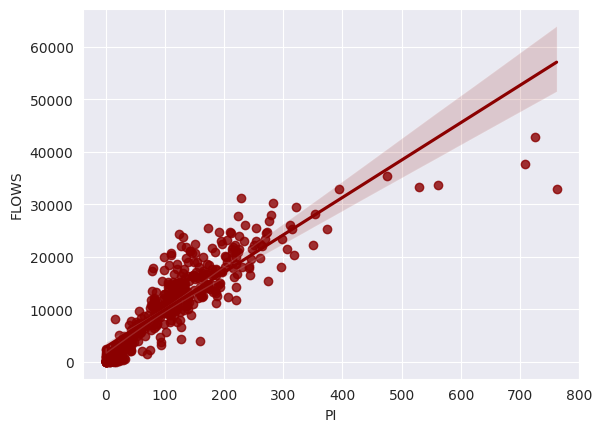

In [ ]:
sns.regplot(x="PI", y="FLOWS", data=features, color='darkred');

y = 71.192 x + 2835.833
Rsq =  0.7806528016479278
p-value of Population =  3.8990299100115214e-138


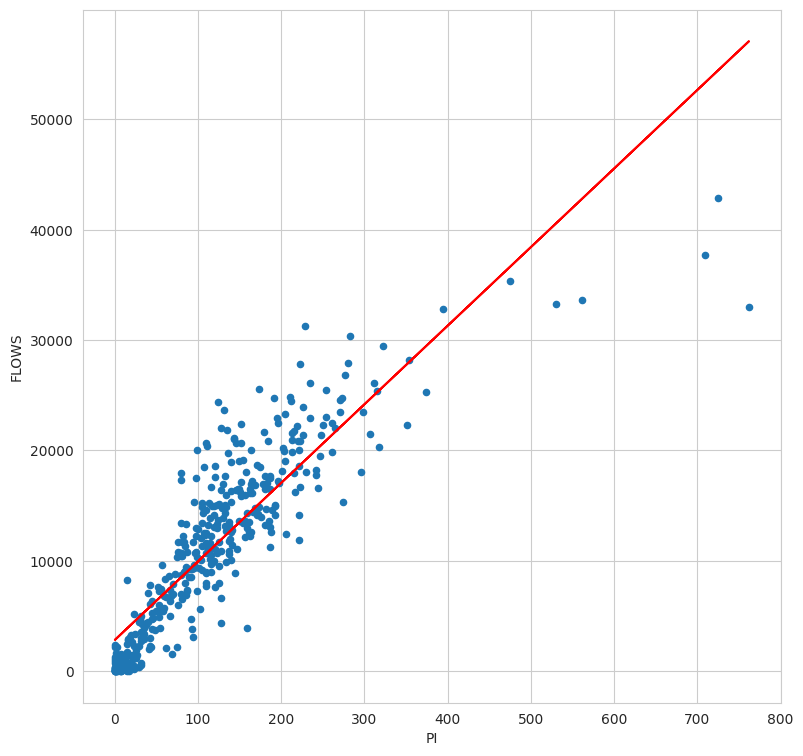

In [ ]:
# plot the result
fig, ax = plt.subplots()
features.plot(kind='scatter', x='PI', y='FLOWS', figsize=(9, 9), ax = ax)

X=features.PI
b = plt.plot(X, X*beta_1 + beta_0, 'r') # Plot the regression line.

print("y =", round(beta_1,3), "x +", round(beta_0,3))
print("Rsq = ", rsq)
print("p-value of Population = ", pval_1)

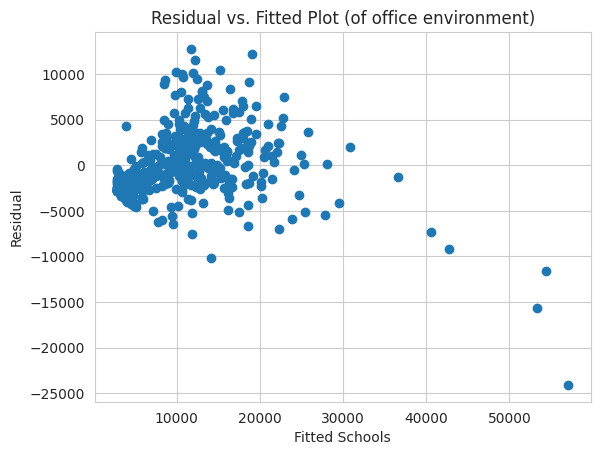

In [ ]:
# plot
plt.scatter(school_pop.fittedvalues, school_pop.resid)
# adding title and labels
plt.xlabel('Fitted Schools')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot (of office environment)')
plt.show()

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   _index   415 non-null    object 
 1   FLOWS    415 non-null    int64  
 2   AED      415 non-null    int64  
 3   AT       415 non-null    int64  
 4   CS       415 non-null    int64  
 5   EH       415 non-null    int64  
 6   MP       415 non-null    int64  
 7   PI       415 non-null    int64  
 8   RT       415 non-null    int64  
 9   SE       415 non-null    int64  
 10  TR       415 non-null    int64  
 11  log_AED  415 non-null    float64
 12  log_AT   415 non-null    float64
 13  log_EH   415 non-null    float64
 14  log_MP   415 non-null    float64
 15  log_PI   415 non-null    float64
 16  log_RT   415 non-null    float64
 17  log_TR   415 non-null    float64
dtypes: float64(7), int64(10), object(1)
memory usage: 61.6+ KB


<Axes: xlabel='TR', ylabel='FLOWS'>

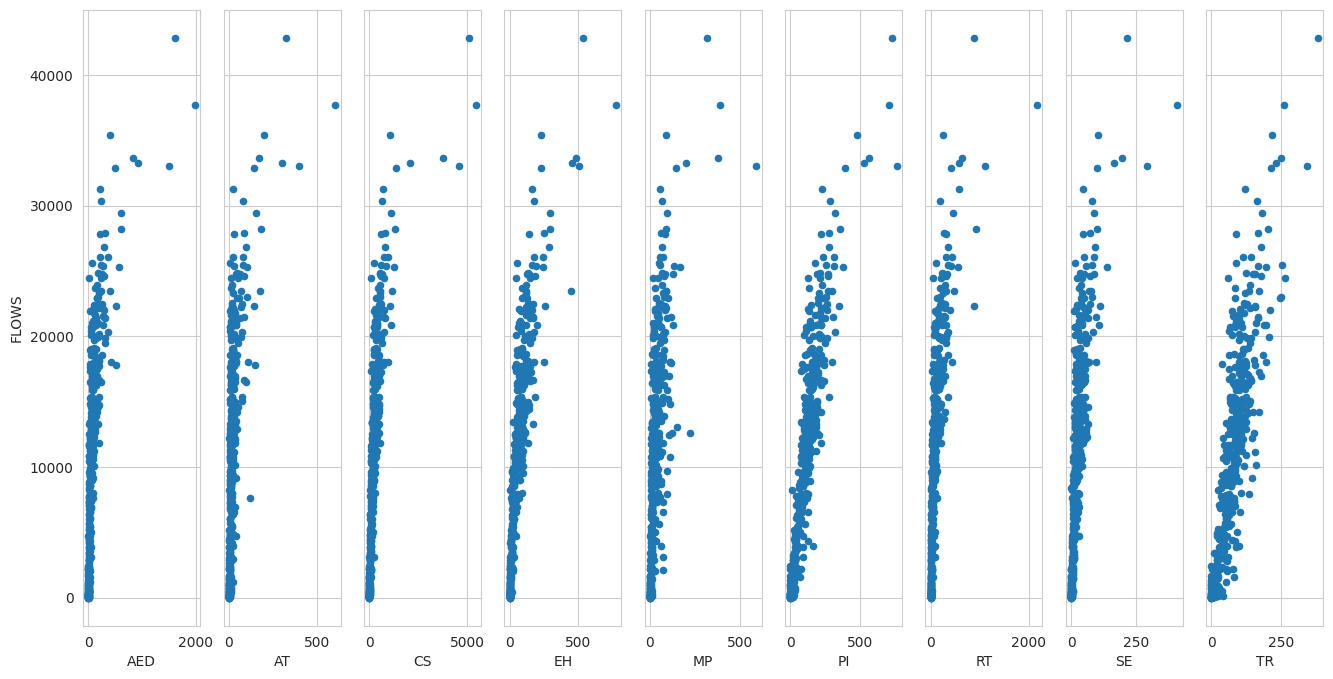

In [ ]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 9, sharey=True)
features.plot(kind='scatter', x='AED', y='FLOWS', ax=axs[0], figsize=(16, 8))
features.plot(kind='scatter', x='AT', y='FLOWS', ax=axs[1])
features.plot(kind='scatter', x='CS', y='FLOWS', ax=axs[2])
features.plot(kind='scatter', x='EH', y='FLOWS', ax=axs[3])
features.plot(kind='scatter', x='MP', y='FLOWS', ax=axs[4])
features.plot(kind='scatter', x='PI', y='FLOWS', ax=axs[5])
features.plot(kind='scatter', x='RT', y='FLOWS', ax=axs[6])
features.plot(kind='scatter', x='SE', y='FLOWS', ax=axs[7])
features.plot(kind='scatter', x='TR', y='FLOWS', ax=axs[8])

In [ ]:
# This performs a multiple regression of expectancy against recycling:

reg_ac = smf.ols(formula='FLOWS ~ AED + AT + CS + EH + MP + PI + RT + SE + TR',data=features).fit()

# And this gives a big summary of the results:
print(reg_ac.summary())

                            OLS Regression Results                            
Dep. Variable:                  FLOWS   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     287.0
Date:                Fri, 01 Sep 2023   Prob (F-statistic):          1.11e-169
Time:                        11:00:33   Log-Likelihood:                -3920.5
No. Observations:                 415   AIC:                             7861.
Df Residuals:                     405   BIC:                             7901.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    915.7761    286.711      3.194      0.0

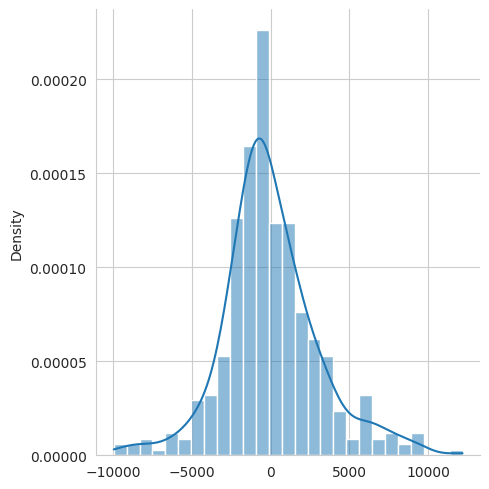

In [ ]:
#the residuals are normally distributed or not.

sn.displot(reg_ac.resid, stat="density", kde = True)